In [18]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from backtest_functions_v2 import *

In [7]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [8]:
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2021-01-01 06:00:00,2.0,0.850000,0.0,0.0,0.0,0.15,0.0,-0.007795,219.4000,351.4194,...,0,0,0,0,0,0,-0.891,-0.891000,-0.111375,-0.111375
2021-01-01 07:00:00,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.003292,253.0935,336.2693,...,0,0,0,0,0,0,-0.594,-0.819720,-0.074250,-0.102465
2021-01-01 08:00:00,2.0,0.400000,0.0,0.0,0.0,0.50,0.0,-0.001883,284.9410,309.6284,...,1,1,1,0,0,0,-0.396,-0.754142,-0.049500,-0.094268
2021-01-01 09:00:00,2.0,-0.050000,0.0,0.0,0.0,0.40,0.0,-0.001648,326.5890,301.5680,...,1,1,1,0,0,0,-0.264,-0.693811,-0.033000,-0.086726
2021-01-01 10:00:00,3.0,0.766667,0.0,0.0,0.0,0.30,0.0,0.000118,351.1670,289.6874,...,1,1,1,0,0,0,-0.176,-0.638306,-0.022000,-0.079788


In [9]:
columns = df.columns.tolist()
for i in range(0, len(columns), 5):
  print(columns[i:i+5])

['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa']
['adoption_absa', 'cybersecurity_absa', 'return_forward', 'sma_5_20_diff', 'sma_20_50_diff']
['sma_50_200_diff', 'ema_5_20_diff', 'ema_20_50_diff', 'ema_50_200_diff', 'sma_5_20_diff_abs_chg']
['sma_5_20_diff_pct_chg', 'sma_20_50_diff_abs_chg', 'sma_20_50_diff_pct_chg', 'sma_50_200_diff_abs_chg', 'sma_50_200_diff_pct_chg']
['ema_5_20_diff_abs_chg', 'ema_5_20_diff_pct_chg', 'ema_20_50_diff_abs_chg', 'ema_20_50_diff_pct_chg', 'ema_50_200_diff_abs_chg']
['ema_50_200_diff_pct_chg', 'macd_12_26', 'signal_line_9', 'macd_histogram', 'macd_position']
['macd_crossover', 'adx', '+di', '-di', 'adx_slope']
['adx_strength', 'di_crossover', 'di_spread', 'adx_di_composite', 'rsi_7']
['rsi_14', 'rsi_7_slope', 'rsi_7_chg', 'rsi_7_acceleration', 'rsi_14_slope']
['rsi_14_chg', 'rsi_14_acceleration', 'rsi_ratio', 'atr_7', 'atr_14']
['atr_7_slope', 'atr_7_chg', 'atr_14_slope', 'atr_14_chg', 'norm_price_change_7']
['norm_p

### Spliting dataset

In [10]:
# list of features column names
all_features = df.columns.drop(['target', 'return_forward'])

In [11]:
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print class distribution
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### Logistic regression model - using all features

In [12]:
pipeline = Pipeline([
  ('scaler', RobustScaler()),
  ('logreg', LogisticRegression(solver='saga', random_state=42, max_iter=15000, class_weight='balanced'))
])

# Parameter grid for GridSearchCV
param_grid = {
  # 'logreg__C': [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
  'logreg__C': [0.01],
  'logreg__penalty': ['l1']
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV - Changed scoring to f1_weighted
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='f1_weighted', n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"GridSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation f1_weighted score: ", grid_search.best_score_)

# Get the best estimator
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
GridSearchCV fitting time: 633.93 seconds
Best parameters found:  {'logreg__C': 0.01, 'logreg__penalty': 'l1'}
Best cross-validation f1_weighted score:  0.2836534145493473


In [13]:
# Make predictions on the test set - Using all features
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# For multiclass ROC AUC, specify multi_class='ovr' or 'ovo' and provide probabilities
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Test Set Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"\nROC AUC Score (One-vs-Rest): {roc_auc:.4f}")

Test Set Accuracy: 0.4105

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.58      0.42      2648
           1       0.68      0.27      0.38      3274
           2       0.43      0.42      0.43      2862

    accuracy                           0.41      8784
   macro avg       0.48      0.42      0.41      8784
weighted avg       0.49      0.41      0.41      8784


Confusion Matrix:
[[1526  212  910]
 [1717  879  678]
 [1452  209 1201]]

ROC AUC Score (One-vs-Rest): 0.6267


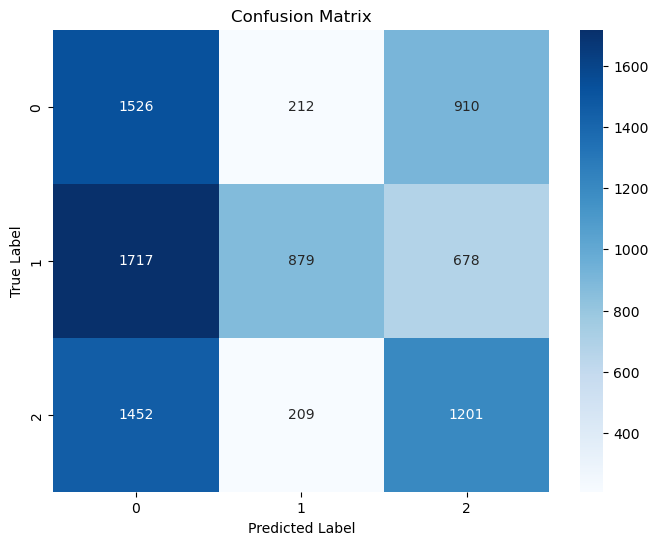

In [14]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Model Coefficients:
                                   Class 0   Class 1   Class 2
news_count                        0.004073 -0.009980  0.001718
tanalysis_absa                   -0.005138  0.004490  0.000000
economy_absa                      0.000000  0.000000  0.000000
regulation_absa                   0.000000  0.000000  0.000000
technology_absa                   0.001635  0.000000 -0.004672
...                                    ...       ...       ...
NER_us_last3                      0.000727 -0.002673  0.000000
reddit_total_sentiment_ewm_5h     0.000493 -0.008359  0.003676
reddit_total_sentiment_ewm_24h    0.004467 -0.017437  0.008779
reddit_average_sentiment_ewm_5h   0.000000  0.006382 -0.003434
reddit_average_sentiment_ewm_24h -0.002878  0.011880 -0.004812

[145 rows x 3 columns]


<Figure size 2500x500 with 0 Axes>

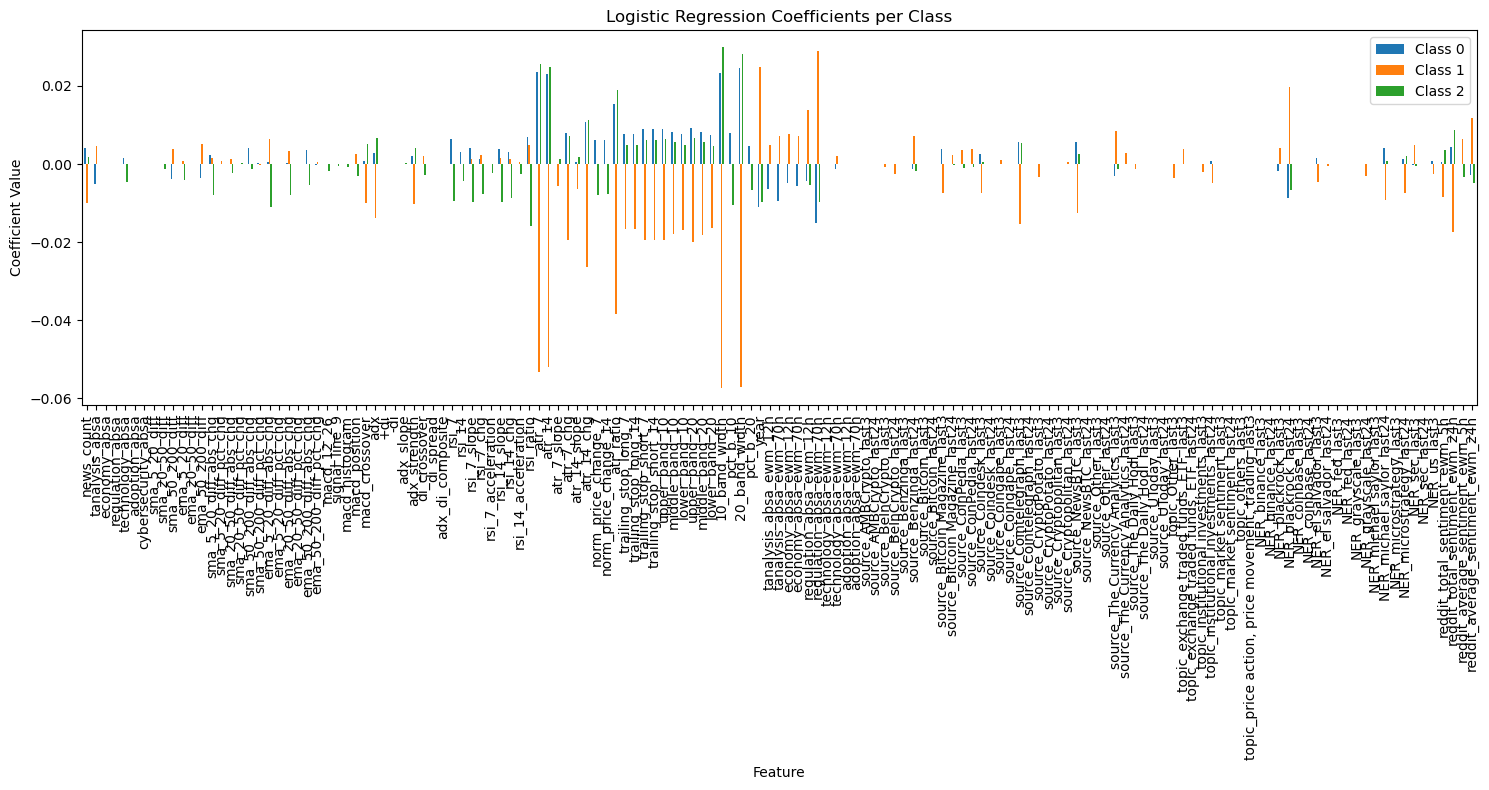

In [15]:
# Get the coefficients from the logistic regression model within the pipeline
coefficients = best_model.named_steps['logreg'].coef_

# Create a DataFrame to display coefficients for each class - Using all features
coef_df = pd.DataFrame(coefficients, columns=all_features, index=['Class 0', 'Class 1', 'Class 2'])

print("Model Coefficients:")
# Transpose for better readability if there are many features
print(coef_df.T)

# Optionally, plot the coefficients for visualization
plt.figure(figsize=(25, 5)) # Adjusted figure size for more features
coef_df.T.plot(kind='bar', figsize=(15, 8)) # Adjusted figure size
plt.title('Logistic Regression Coefficients per Class')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()

In [16]:
# Make prediction on the test set using the best model - Using all features
df_test['signal'] = best_model.predict(X_test)

# Display the first few rows with the new signal column
print(df_test[['target', 'signal']].head())

# Check the distribution of the predicted signals
print("\nPredicted signal distribution:")
print(df_test['signal'].value_counts())

                     target  signal
2024-01-01 00:00:00       0       1
2024-01-01 01:00:00       1       1
2024-01-01 02:00:00       0       1
2024-01-01 03:00:00       1       2
2024-01-01 04:00:00       2       2

Predicted signal distribution:
signal
0    4695
2    2789
1    1300
Name: count, dtype: int64


Overall Annual Return: -28.57%
Overall Annual Sharpe Ratio: -0.4058
Maximum Drawdown: -39.58 %
Alpha: -0.0874
Beta: -0.1237

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.285711    0.509212    -0.123722      -0.09148      -0.405826


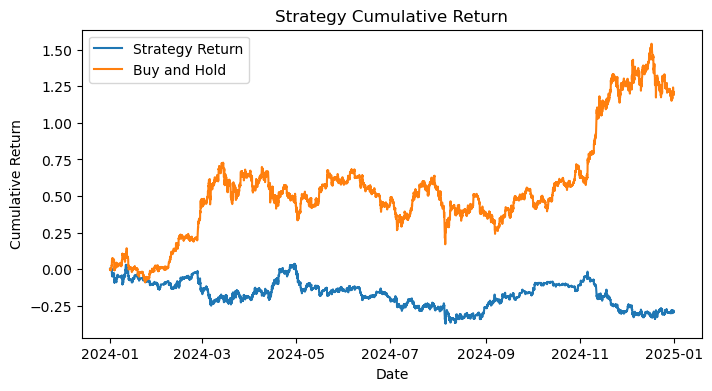

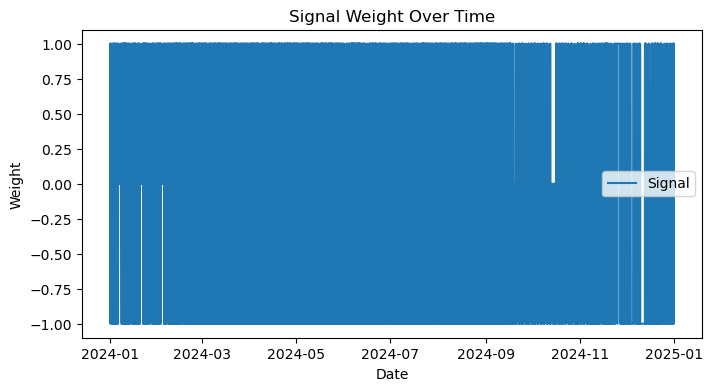

In [17]:
df_test['signal'] = df_test['signal'] - 1
run_backtest(df_test, 'h')